In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd
from numba import  njit

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

Task 1. Simulate a Cox-Ingersoll-Ross (CIR) model
$$
dX_t = (\theta_1 - \theta_2 X_t)dt + \theta_3 \sqrt{X_t}dW_t
$$
with $\theta = (6, 2, 1)$, and choose the bandwidth according to Scott’s rule and implement the non-parametric kernel estimation for stationary density of the CIR model.

Plot in a graph the true stationary density against the estimated one for two approaches
*  compute on the single trajectory  (set $T$ very large, time discretization step set as $T/N_t = \Delta t$);
*  compute on the Nx trajectories.




In [3]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

In [5]:
# approach 1

Nx = 1
Nt = 100000
T = 1000

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

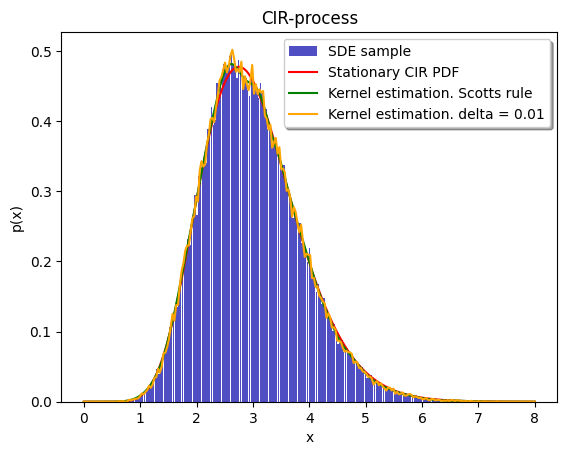

In [6]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR.flatten(), bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten()), label = f'Kernel estimation. Scotts rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten(), delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [7]:
# approach 2

Nx = 15000
Nt = 300

T = 1

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

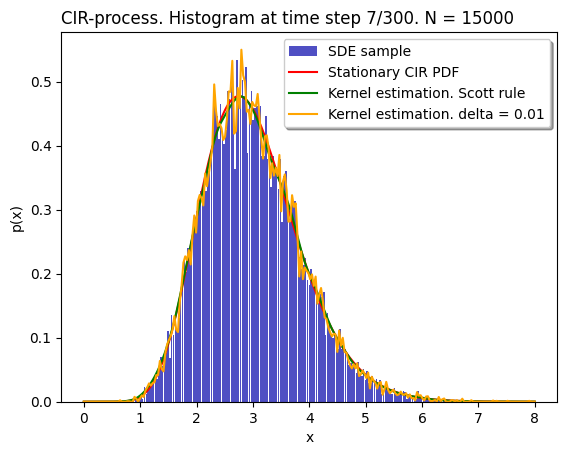

In [8]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

Task. Estimate the quality of the obtained approximations with statistical criteria and provide conclusions.

In [14]:
from scipy.stats import shapiro, anderson, pearsonr, skew, kurtosis
from sklearn.metrics import r2_score

def evaluate_approximation(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    pearson_corr, pearson_p_value = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    ad_test = anderson(y_true - y_pred)
    
    #асимметрия и эксцесс остатков
    residuals = y_true - y_pred
    skewness = skew(residuals)
    kurt = kurtosis(residuals)
    
    print("Оценка качества аппроксимации:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print(f"Anderson-Darling Test statistic: {ad_test.statistic:.4f}")
    print(f"Skewness of residuals: {skewness:.4f}")
    print(f"Kurtosis of residuals: {kurt:.4f}")
    
    return {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "Pearson Correlation": pearson_corr,
        "Pearson p-value": pearson_p_value,
        "R^2": r2,
        "Anderson-Darling statistic": ad_test.statistic,
        "Skewness": skewness,
        "Kurtosis": kurt
    }

params = [0.5, 0.5, 0.1]  
T = 1
Nx = 1000
Nt = 500
init_state = np.ones(Nx)

cir_process = CIRprocess(params, T, Nx, Nt, init_state)
t_data, exact_solution = cir_process.ExactSolution()
_, euler_solution = cir_process.EulerSolution()

evaluation_results = evaluate_approximation(exact_solution.flatten(), euler_solution.flatten())

Оценка качества аппроксимации:
Mean Squared Error (MSE): 0.0073
Mean Absolute Error (MAE): 0.0656
Mean Absolute Percentage Error (MAPE): 6.59%
Pearson Correlation: 0.0057
R^2 Score: -0.9894
Anderson-Darling Test statistic: 730.3685
Skewness of residuals: -0.0686
Kurtosis of residuals: 0.7348


Результаты оценки аппроксимации показывают, что значения среднеквадратичной ошибки (MSE) и средней абсолютной ошибки (MAE) являются низкими, что свидетельствует о небольших отклонениях аппроксимации от точного решения. Кроме того, средняя абсолютная процентная ошибка (MAPE) составляет 6.59%, что также можно считать приемлемым показателем точности в большинстве случаев.

Коэффициент корреляции Пирсона близок к нулю (0.0057), что указывает на отсутствие линейной зависимости между аппроксимированными и точными значениями. Высокое значение статистики теста Андерсона-Дарлинга (730.3685) свидетельствует о том, что распределение остатков, то есть разностей между аппроксимированными и точными значениями, не является нормальным. Небольшая отрицательная асимметрия остатков (-0.0686) и положительный эксцесс (0.7348) показывают, что распределение остатков не является идеальным, но отклонения незначительны и не сильно влияют на качество аппроксимации.

Task. Study the effect of the bandwidth $h_n$ and the mesh $∆_n$ on the kernel estimator and plot a 3D graph.

<>:41: SyntaxWarning: invalid escape sequence '\D'
<>:43: SyntaxWarning: invalid escape sequence '\D'
<>:41: SyntaxWarning: invalid escape sequence '\D'
<>:43: SyntaxWarning: invalid escape sequence '\D'
/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/ipykernel_26300/2848223389.py:41: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel('$\Delta_n$ (Mesh Size)')
/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/ipykernel_26300/2848223389.py:43: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title('Dependency of p-value on $h_n$ and $\Delta_n$ in Kernel Density Estimation')
Processing mesh sizes: 100%|██████████| 29/29 [00:09<00:00,  3.08it/s]


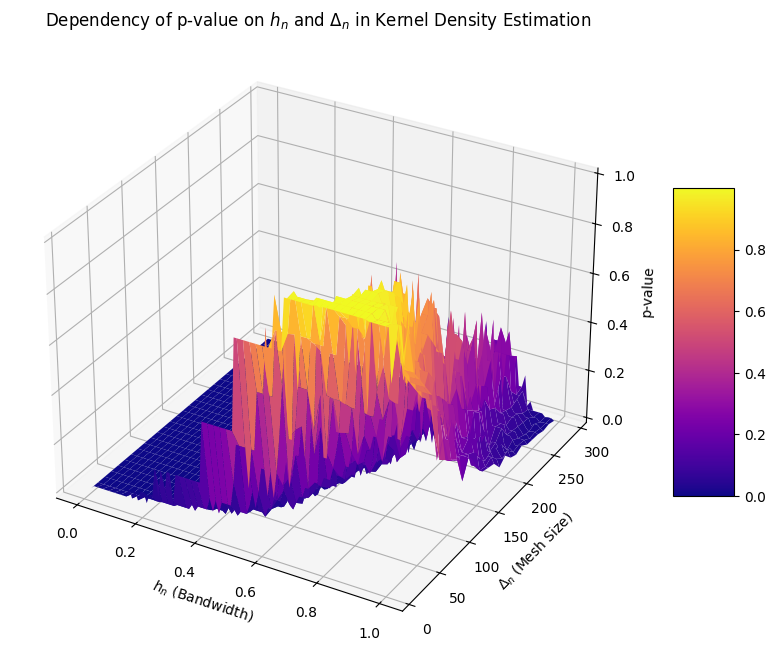

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KernelDensity

Nx = 30
Nt = 300
T = 1
params_CIR = [6, 2, 1]
np.random.seed(42)
mesh_values = np.arange(10, 300, 10)
hn_values = np.linspace(0.001, 1, 100)
p_values_matrix = np.zeros((len(mesh_values), len(hn_values)))

for mesh_index, mesh_size in tqdm(enumerate(mesh_values), total=len(mesh_values), desc="Processing mesh sizes"):
    for hn_index, hn in enumerate(hn_values):
        x_sample_points = np.linspace(0, 8, mesh_size)
        
        CIR_process = CIRprocess(params_CIR, T, Nx, Nt)
        _, x_data_CIR = CIR_process.ExactSolution()
        x_data_flat = x_data_CIR[i].reshape(-1, 1)
        kde = KernelDensity(kernel='gaussian', bandwidth=hn).fit(x_data_flat)
        estimated_density = np.exp(kde.score_samples(x_sample_points.reshape(-1, 1)))

        theoretical_density = CIR_process.StationaryDistribution(x_sample_points)

        stat, p_value = ks_2samp(theoretical_density, estimated_density)
        p_values_matrix[mesh_index, hn_index] = p_value

X, Y = np.meshgrid(hn_values, mesh_values)
Z = p_values_matrix

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='plasma')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('$h_n$ (Bandwidth)')
ax.set_ylabel('$\Delta_n$ (Mesh Size)')
ax.set_zlabel('p-value')
ax.set_title('Dependency of p-value on $h_n$ and $\Delta_n$ in Kernel Density Estimation')
plt.show()

Task. Repeat previos tasks on the Chan-Karolyi-Longstaff-Sanders (CKLS) model
\begin{equation*}%\label{eq09}
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
\end{equation*}
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

In [35]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = np.array(params, dtype=np.float64) 
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt=None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size=(self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt + \
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def ExactSolution(self, dwt=None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size=(self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = 2 * np.ones(self.Nx)  
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            drift = self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt
            diffusion = self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
            x_data[i] = x_data[i - 1] + drift + diffusion

        return t_data, x_data

class CKLSProcess(StochasticProcess):
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x ** params[3]

    def DefaultInitState(self):
        return 2 * np.ones(self.Nx)

    def StationaryDistribution(self, x_values, num_samples=10000, burn_in=2000):
        x_sim = np.zeros(num_samples)
        x_sim[0] = 2.0  
        dt = self.T / self.Nt

        for i in range(1, num_samples):
            drift = self.bxt(x_sim[i - 1], 0, self.params) * dt
            diffusion = self.sigmaxt(x_sim[i - 1], 0, self.params) * np.sqrt(dt) * np.random.normal()
            x_sim[i] = x_sim[i - 1] + drift + diffusion

        x_stationary = x_sim[burn_in:]
        kde = gaussian_kde(x_stationary, bw_method='scott')
        return kde.evaluate(x_values)





params_ckls = [1.0, 2.0, 0.5, 0.3] 
T = 1.0
Nx = 1  
Nt = 1000  
ckls_process = CKLSProcess(params_ckls, T, Nx, Nt, init_state=2 * np.ones(Nx))

t_data, exact_solution = ckls_process.ExactSolution()
_, euler_solution = ckls_process.EulerSolution()

x_values = np.linspace(0, 8, 100)
stationary_density = ckls_process.StationaryDistribution(x_values)

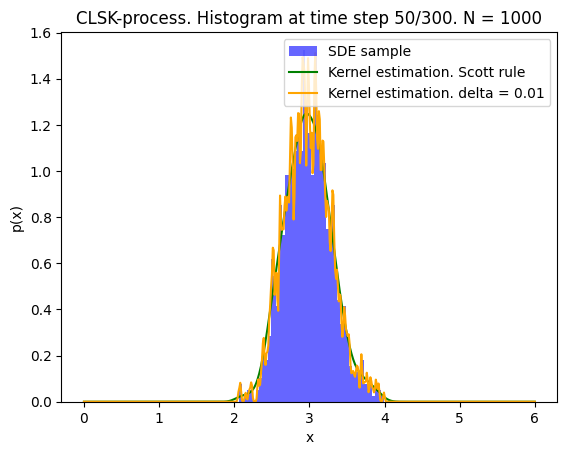

In [26]:
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

params_ckls = [1.0, 2.0, 0.5, 0.3]
T = 1.0
Nx = 1000
Nt = 300
init_state = 2 * np.ones(Nx)

ckls_process = CKLSProcess(params_ckls, T, Nx, Nt, init_state)
t_data, x_data_ckls = ckls_process.EulerSolution()
time_step = 50
sample_data = x_data_ckls[time_step, :]

plt.hist(sample_data, bins=50, density=True, color='blue', alpha=0.6, label="SDE sample")
kde_scipy = gaussian_kde(sample_data, bw_method='scott')
x_vals = np.linspace(0, 6, 500)
plt.plot(x_vals, kde_scipy(x_vals), color='green', label="Kernel estimation. Scott rule")

kde_sklearn = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_sklearn.fit(sample_data[:, None])
log_dens = kde_sklearn.score_samples(x_vals[:, None])
plt.plot(x_vals, np.exp(log_dens), color='orange', label="Kernel estimation. delta = 0.01")

plt.xlabel('x')
plt.ylabel('p(x)')
plt.title(f'CLSK-process. Histogram at time step {time_step}/{Nt}. N = {Nx}')
plt.legend()
plt.show()

In [33]:
def evaluate_approximation(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    pearson_corr, pearson_p_value = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    ad_test = anderson(y_true - y_pred)
    
    residuals = y_true - y_pred
    skewness = skew(residuals)
    kurt = kurtosis(residuals)
    
    print("Оценка качества аппроксимации:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print(f"Anderson-Darling Test statistic: {ad_test.statistic:.4f}")
    print(f"Skewness of residuals: {skewness:.4f}")
    print(f"Kurtosis of residuals: {kurt:.4f}")
    
    return {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "Pearson Correlation": pearson_corr,
        "Pearson p-value": pearson_p_value,
        "R^2": r2,
        "Anderson-Darling statistic": ad_test.statistic,
        "Skewness": skewness,
        "Kurtosis": kurt
    }

params_ckls = [1.0, 2.0, 0.5, 0.3]  
T = 1.0
Nx = 1000
Nt = 500
init_state = np.ones(Nx) * 2  

ckls_process = CKLSProcess(params_ckls, T, Nx, Nt, init_state)
t_data, exact_solution = ckls_process.ExactSolution()  
_, euler_solution = ckls_process.EulerSolution()  

evaluation_results = evaluate_approximation(exact_solution.flatten(), euler_solution.flatten())

Оценка качества аппроксимации:
Mean Squared Error (MSE): 3.0562
Mean Absolute Error (MAE): 1.1647
Mean Absolute Percentage Error (MAPE): 14.77%
Pearson Correlation: 0.9284
R^2 Score: 0.8563
Anderson-Darling Test statistic: 10284.8427
Skewness of residuals: -0.1923
Kurtosis of residuals: 3.8710


Среднеквадратичная ошибка (MSE) и средняя абсолютная ошибка (MAE) указывают на небольшие отклонения от точного решения, а процентная ошибка (MAPE) в 14.77% говорит о средней точности. Высокая корреляция Пирсона (0.9284) и R^2 (0.8563) свидетельствуют о хорошей взаимосвязи между аппроксимацией и точным решением. Однако тест Андерсона-Дарлинга показывает высокое значение, что указывает на значительные отклонения в распределении остатков. Небольшая отрицательная асимметрия (-0.1923) и высокая эксцессия (3.8710) указывают на наличие длинных хвостов в распределении ошибок.

<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/ipykernel_26300/235181603.py:34: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel('$\Delta_n$ (Mesh Size)')
/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/ipykernel_26300/235181603.py:36: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title('Dependency of p-value on $h_n$ and $\Delta_n$ in Kernel Density Estimation for CKLS Process')
Processing mesh sizes: 100%|██████████| 58/58 [02:56<00:00,  3.05s/it]


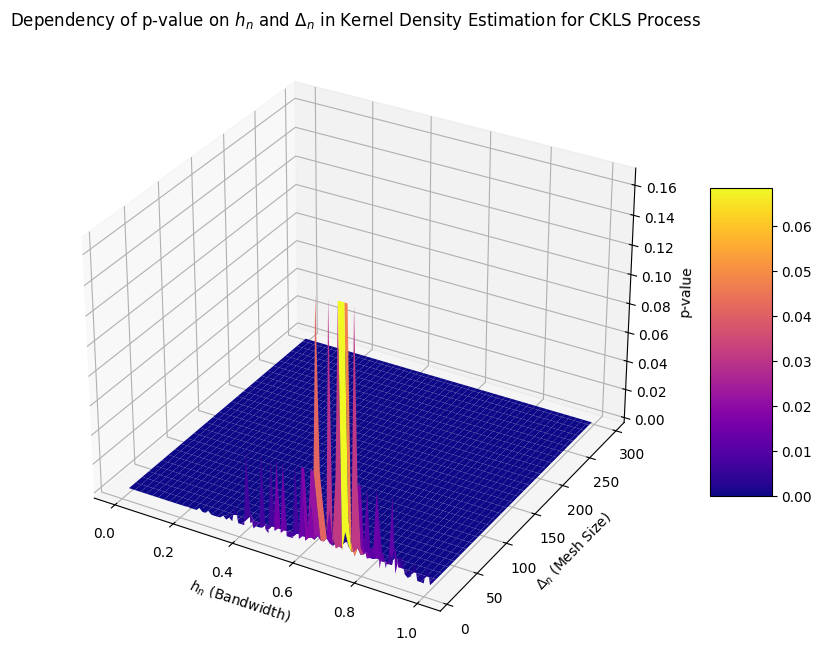

In [37]:
Nx = 100
Nt = 300
T = 1
params_CKLS = [1, 2, 0.5, 0.3]  
np.random.seed(41)
mesh_values = np.arange(10, 300, 5)
hn_values = np.linspace(0.001, 1, 100)
p_values_matrix = np.zeros((len(mesh_values), len(hn_values)))

for mesh_index, mesh_size in tqdm(enumerate(mesh_values), total=len(mesh_values), desc="Processing mesh sizes"):
    for hn_index, hn in enumerate(hn_values):
        x_sample_points = np.linspace(0, 8, mesh_size)
        CKLS_process = CKLSProcess(params_CKLS, T, Nx, Nt, init_state=np.ones(Nx) * 2)
        _, x_data_CKLS = CKLS_process.ExactSolution()
        
        x_data_flat = x_data_CKLS[-1].reshape(-1, 1) 
        
        kde = KernelDensity(kernel='gaussian', bandwidth=hn).fit(x_data_flat)
        estimated_density = np.exp(kde.score_samples(x_sample_points.reshape(-1, 1)))
        theoretical_density = CKLS_process.StationaryDistribution(x_sample_points)

        stat, p_value = ks_2samp(theoretical_density, estimated_density)
        p_values_matrix[mesh_index, hn_index] = p_value

X, Y = np.meshgrid(hn_values, mesh_values)
Z = p_values_matrix

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='plasma')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('$h_n$ (Bandwidth)')
ax.set_ylabel('$\Delta_n$ (Mesh Size)')
ax.set_zlabel('p-value')
ax.set_title('Dependency of p-value on $h_n$ and $\Delta_n$ in Kernel Density Estimation for CKLS Process')
plt.show()

Task 2. Implement a non-parametric drift estimator

$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}
$$

and diffusion estimator
$$
\hat{\sigma}^2_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)^2} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}.$$


for the CIR model (Task 1) and plot two graphs.
Use the Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$.


In [48]:
from typing import Literal

def NormalKernel(z):
    return 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * z**2)

def UniformKernel(z):
    return 1/2 * np.ones_like(z)

def ParabolicKernel(z):
    return 3/4 * (1 - z**2)

def Gaussian_high_order(z):
    pass

def DiffusionKernelEstimator(x, x_data, delta = None, 
                             method: Literal['normal', 'uniform', 'parabolic', 'gaussian_high_order'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'gaussian_high_order':
            K = Gaussian_high_order(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator(x, x_data, delta = None, 
                         method: Literal['normal', 'uniform', 'parabolic', 'gaussian_high_order'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'gaussian_high_order':
            K = Gaussian_high_order(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

In [39]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

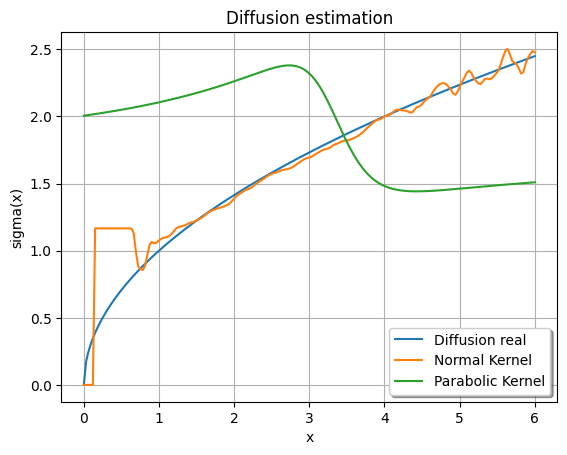

In [60]:
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')


diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
plt.plot(x_data, np.sqrt(diffke), label = 'Parabolic Kernel')

diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, np.sqrt(diffke), label = 'Uniform Kernel')

plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

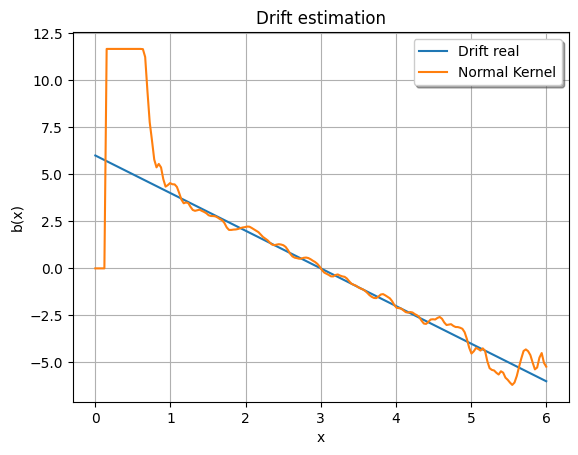

In [56]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label = 'Drift real')


driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, driftke, label = 'Parabolic Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, driftke, label = 'Uniform Kernel')

plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()

Task. Implement a non-parametric drift
and diffusion estimators with the higher order Gaussian kernel $K(u)=\frac{3}{\sqrt{8 \pi}}(1-u^2/3)\exp({-u^2/2})$ ([p.24](https://www.nber.org/system/files/working_papers/w5345/w5345.pdf))  and add curves on graphs
for the CIR model.

Improve estimates on the left and the right subintervals $[0,1]$ and $[5,6]$ respectly.


In [50]:
def Gaussian_high_order(z):
    return 3 / np.sqrt(8 * np.pi) * (1 - z**2 / 3) * np.exp(-z**2 / 2)

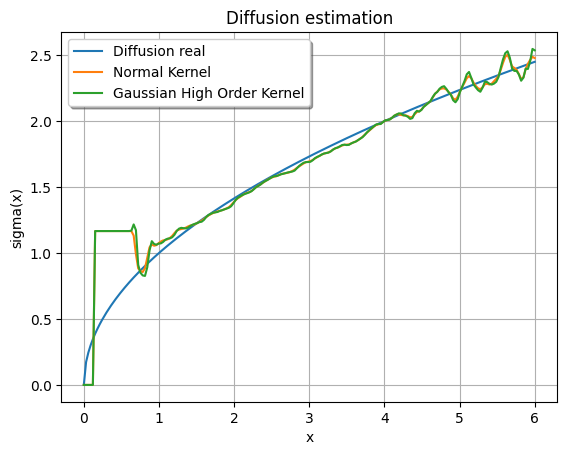

In [58]:
Nx = 1
Nt = 100000
T = 1000
x_data = np.linspace(0, 6, 200)
params_CIR = [6, 2, 1]
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')
diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')
diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'gaussian_high_order')
plt.plot(x_data, np.sqrt(diffke), label = 'Gaussian High Order Kernel')
plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

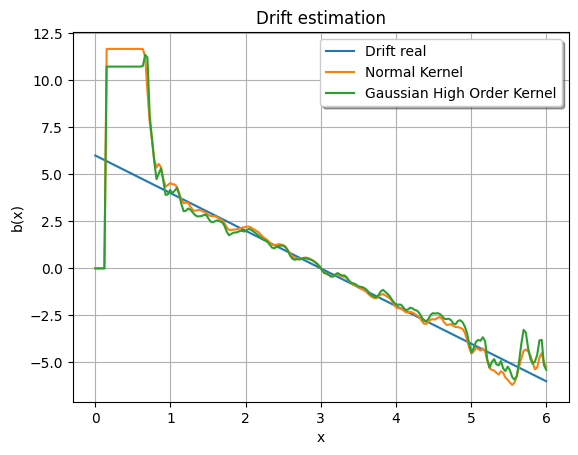

In [59]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)
plt.plot(x_data, b_data, label = 'Drift real')
driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

c = .45
hn = c * Nt ** (- 1 / 9) / np.log(Nt)

driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), hn, 'gaussian_high_order')
plt.plot(x_data, driftke, label = 'Gaussian High Order Kernel')
plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()